In [1]:
using Plots
using LaTeXStrings, ColorSchemes
using CSV, DataFrames
Plots.PyPlotBackend()

plot_font = "Computer Modern"
default(fontfamily=plot_font, grid=false, color=ColorSchemes.berlin[1])

function fluid_plot(sol, time_skip, save_every, x, s, tmax)
    dt = floor(Int64, time_skip / save_every)
    plt = plot(x, s, dpi=200, xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$", legend=false, color="black",
        title=L"Fluid profile at $\delta t = %$time_skip$ intervals", ylims=(0, Inf), xlims=(0, Lx))
    for i = 1:floor(Int64, tmax / time_skip)+1
        plot!(plt, x, sol.u[1+dt*(i-1)][2:end-1] + s)
    end
    plot!(plt, x, s, color="black")
    return plt
end

function fluid_anim(sol, ymax, xmax, x, s)
    anim = @animate for i = 1:size(sol.u)[1]
        timestep = sol.t[i]
        plot(x, sol.u[i][2:end-1] + s, legend=false, ylims=(0, ymax), xlims=(0, Lx), title=L"Fluid Profile $(t=%$timestep)$",
            xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$")
        plot!(x, s, color="black")
    end
    return anim
end

"""
Function to save fluid profile data to a CSV. CSV saved in the format of:
Timestamp | Ghost 1 | 0 | ... | Lx | Ghost 2
# Arguments
- `sol`: solution object of DiffEq solver
"""
function fluid_data(sol, path)
    CSV.write(path * "/data.csv", DataFrame(sol))
end

function save_params(path, filename="params")
    open(path * "/" * filename * ".txt", "w") do f
        domain_info = "# Domain Parameters\nnx: $nx\nLx: $Lx\ndx: $dx\n"
        topo_info = "\n# Topography Parameters\n$topo\n"
        init_cond_info = "\n# Initial Condition Parameters\n$ic_obj\n"
        ode_sys_info = "\n# ODE System Parameters\nD: $D\nC: $C\nalpha: $α\n"
        time_info = "\n# Time Parameters\ntime_span: $tspan\ntimestep_save: $save_every"
        write(f, domain_info * topo_info * init_cond_info * ode_sys_info * time_info)
    end
end

save_params (generic function with 2 methods)

In [2]:
"""
Custom struct for topogrpahy functions
"""
struct Topography
    f::Function
    params::Tuple
end

"""
Function describing a flat plane
"""
function flat(x)
    0
end

"""
Function describing a bump
# Arguments
- `x`: x coordinate
- `w`: width scaling
- `c`: x coordinate for the center of the bump
- `h`: optional arg for height scaling
"""
function bump(x, w, c, h=1)
    if x <= c - w || x >= c + w
        return 0
    else
        return h * exp(-(w^2 / (w^2 - (x - c)^2)))
    end
end

"""
Function describing a rectangular mound
# Arguments
- `x`: x coordinate
- `c`: x coordinate for left hand corner of mound
- `h`: height of mound
- `delta`: steepness of mound
- `w`: width of mound
"""
function mound(x, c, h, delta, w)
    h * (1 / pi * (atan((x - c) / delta) - atan((x - c - w) / delta)))
end

"""
Custom struct for initial condition functions
"""
struct InitialCondition
    f::Function
    params::Tuple
end

"""
Function describing a reflected sigmoid
# Arguments
- `x`: x coordinate
- `b`: precursor film height
- `xf`: center point of transition
- `c`: steepness of transition
- `h`: optional argument control initial height
"""
function reflected_sigmoid(x, b, xf, c, h=1)
    b + (h - b) / (1 + exp(1 / c * (x - xf)))
end

"""
Function describing a flat plane with respect to phi = 0
# Arguments
- `h`: film height relative to phi = 0
- `s`: topography
"""
function flat_profile(x, h, s, b=0.0)
    h - s + b
end

function front_tanh(x)
    0.45 * tanh(-5 * (x - 5)) + 0.55
end

"""
Function describing a bump
# Arguments
- `x`: x coordinate
- `w`: width scaling
- `c`: x coordinate for the center of the bump
- `b`: precursor film height
- `h`: optional arg for height scaling
"""
function ic_bump(x, w, c, b, h=1)
    if x <= c - w || x >= c + w
        return b
    else
        return h * exp(-(w^2 / (w^2 - (x - c)^2))) + b
    end
end

ic_bump

In [246]:
plot_font = "Computer Modern"
default(fontfamily=plot_font, grid=false)
# ================================
# Discretization of x-domain
# ================================
Lx = 40
dx = 0.05
nx = Lx / dx
x = 0.0:dx:Lx

# ================================
# Topography definition
# ================================
topo = Topography(flat, ())
s = topo.f.(x, topo.params...)

# ================================
# Initial Condition definition
# ================================
b = 0.05
c = 15
w = 1
h = ℯ*.9
ic_obj = InitialCondition(ic_bump, (w, c, b, h))
ic = ic_obj.f.(x, ic_obj.params...)

# Adding ghost points
pushfirst!(ic, ic[1])
push!(ic, ic[end])

# ================================
# Parameters of the system of ODEs
# ================================

α = 0
g = 9.8 # m/s^2

# Oil Physical Properties
ρ = 900 # kg/m^3
γ = 20 * 10^(-3) # kg/s^2
μ = 50 * 10^(-6) # kg*m/s
mu = 0.045

# Saw Forcing Properties
A = 8 * 10^(-10) # m 
ω = 40 * pi * 10^6 # 1/s
α_1 = 2.386
k_i = -1000 # 1/m 

# Scaling Factors
h_c = 200 * 10^(-6)
x_c = ((γ * h_c) / (ρ * g))^(1 / 3)
t_c = (3 * μ * x_c) / (h_c^2 * ρ * g)

# Compact Dimless Params
Ca = (h_c^2 * ρ * g) / (3 * γ)
D = (3 * Ca)^(1 / 3)
C = ((1 + α_1^2) * A^2 * ω^2 * k_i) / g

xsym = Symbol.(x)
pushfirst!(xsym, Symbol("ghost1"))
push!(xsym, Symbol("ghost2"))
print("End")

End

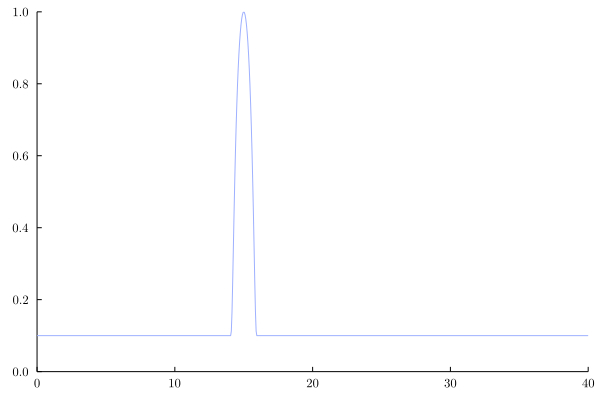

In [241]:
plot(x, ic[2:end-1], legend=false, xlims=(0, Lx), ylims=(0, Inf))

In [153]:
"""
Builds the system of ODEs (represented by du)
u = (h_-1, h_0, ..., h_nx, h_nx+1) where h_-1 and h_nx+1 are ghost points
"""
function system!(du, u, p, t)
    D, alpha, dx, C, k_i, topo, params, xl, xr = p

    function phi(i)
        u[i] + topo(dx * (i - 2), params...)
    end
    function interp(i)
        1 / 2 * (u[i]^3 + u[i+1]^3)
    end
    function f1(i)
        1 / (dx^2) * (interp(i - 1) * (phi(i - 1) - phi(i)) + interp(i) * (phi(i + 1) - phi(i)))
    end
    function f2(i)
        (1 / dx^4) * (interp(i - 1) * (phi(i - 2) - 3 * phi(i - 1) + 3 * phi(i) - phi(i + 1)) + interp(i) * (-phi(i - 1) + 3 * phi(i) - 3 * phi(i + 1) + phi(i + 2)))
    end
    function f3(i)
        (1 / (2 * dx)) * (u[i+1]^3 - u[i-1]^3)
    end
    function f4(i, x0)

        function expo(j, x_front)
            x_j = dx * (j - 2)
            return exp(2 * k_i * (x_j - x_front))
        end

        (1 / (2 * dx)) * ((u[i+1]^3 * expo(i + 1, x0)) - (u[i-1]^3 * expo(i - 1, x0)))
        #(1/(2*dx)) * (expo(i)*(u[i+1]^3 + u[i]^3) - expo(i-1)*(u[i]^3 + u[i-1]^3))
    end

    du[1] = 0
    du[2] = 0
    du[end-1] = 0
    du[end] = 0
    for i in 3:length(u)-2
        x_i = dx * (i - 2)
        if x_i >= xl && x_i <= xr
            du[i] = D * cos(alpha) * f1(i) - f2(i) - sin(alpha) * f3(i) + C * f4(i, xl)
        else
            du[i] = D * cos(alpha) * f1(i) - f2(i) - sin(alpha) * f3(i)
        end
    end
    return du
end

system!

In [247]:
using DifferentialEquations
using DiffEqCallbacks
using Interpolations, Roots

function inflection_point!(u, t, integrator)
    h = integrator(integrator.t, Val{0})[2:end-1]
    h1 = integrator(integrator.t, Val{1})[2:end-1]
    h2 = integrator(integrator.t, Val{2})[2:end-1]
    interp = LinearInterpolation(x, h2)
    x_min = dx * (findmin(h)[2] - 1)
    x0 = find_zero(interp, x_min)
    integrator.p[8] = x0
end


function inflection_point_new!(u, t, integrator)
    h = integrator(integrator.t, Val{0})[2:end-1]
    #h2 = integrator(integrator.t, Val{1})[2:end-1]

    #interp = LinearInterpolation(x, h2)

    x_max_idx = (findmax(h)[2])
    x_max = dx * (x_max_idx-1)

    x_min_left = dx * (findmin(h[1:x_max_idx])[2] - 1)
    x_min_right = dx * (findmin(h[x_max_idx+1:end])[2]) + x_max

    #integrator.p[8] = find_zero(interp, x_min_left) #x_min_left
    #integrator.p[9] = find_zero(interp, x_min_right)

    integrator.p[8] = x_min_left
    integrator.p[9] = x_min_right
end

func = 0
func_first = 0
func_sec = 0
function condition(u, t, integrator)
    t == 0.1
end
function affect(integrator)
    println("Affect!")
    global func = integrator(integrator.t, Val{0})[2:end-1]
    global func_first = integrator(integrator.t, Val{1})[2:end-1]
    global func_sec = integrator(integrator.t, Val{2})[2:end-1]
end
#cb = DiscreteCallback(condition, affect)

xl = 14
xr = 16
p = [D, α, dx, C, k_i * x_c, topo.f, topo.params, xl, xr]
tspan = (0.0, 300.0);
save_every = 0.5;
f = ODEFunction(system!, syms=xsym)
prob = ODEProblem(f, ic, tspan, p, saveat=save_every)
#cb = DiffEqCallbacks.FunctionCallingCallback(inflection_point!; func_everystep=true, func_start=false)
cb = DiffEqCallbacks.FunctionCallingCallback(inflection_point_new!; func_everystep=true, func_start=false)
sol = solve(prob, alg=Rodas4(), callback=cb, tstops=[0.1])
#sol = solve(prob, alg=Rodas4())
#print("END")

retcode: Success
Interpolation: 1st order linear
t: 601-element Vector{Float64}:
   0.0
   0.5
   1.0
   1.5
   2.0
   2.5
   3.0
   3.5
   4.0
   4.5
   ⋮
 296.0
 296.5
 297.0
 297.5
 298.0
 298.5
 299.0
 299.5
 300.0
u: 601-element Vector{Vector{Float64}}:
 [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05  …  0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
 [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05  …  0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
 [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05  …  0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
 [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05  …  0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
 [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05  …  0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
 [0.05000000000000001, 0.05000000000000001, 0.05000000000000001, 0.05000000000000001, 0.05000000000000001, 0.0500000

In [190]:
using Interpolations, Roots

interp = LinearInterpolation(x, func_sec)
x_max_idx = (findmax(func)[2])
x_max = dx * (x_max_idx-1)

x_min_left = dx * (findmin(func[1:x_max_idx])[2] - 1)
x_min_right = dx * (findmin(func[x_max_idx+1:end])[2]) + x_max
#xl = find_zeros(interp, x_min-0.01, x_min+0.01)
#xasdf = find_zero(interp, x_min)
println(x_min_left)
println(x_min_right)

9.05
10.950000000000001


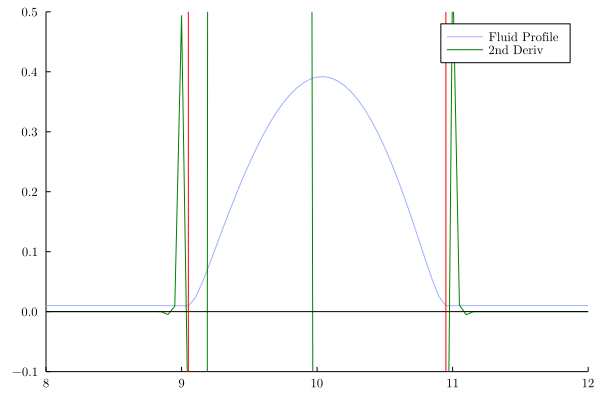

In [191]:
plot(x, func, xlims=(8, 12), ylims=(-0.1, 0.5), label="Fluid Profile")
#plot!(x, func_first, color="red", label="1st Deriv")
plot!(x, func_sec, color="green", label="2nd Deriv")
plot!(x, flat.(x), color="black", label="")
plot!([x_min_left], seriestype="vline", color="red", label="")
plot!([x_min_right], seriestype="vline", color="red", label="")

In [243]:
time_skip = 15
plt = fluid_plot(sol, time_skip, save_every, x, s, tspan[2])
anim = fluid_anim(sol, 1.5, Lx, x, s)
print("End")

End

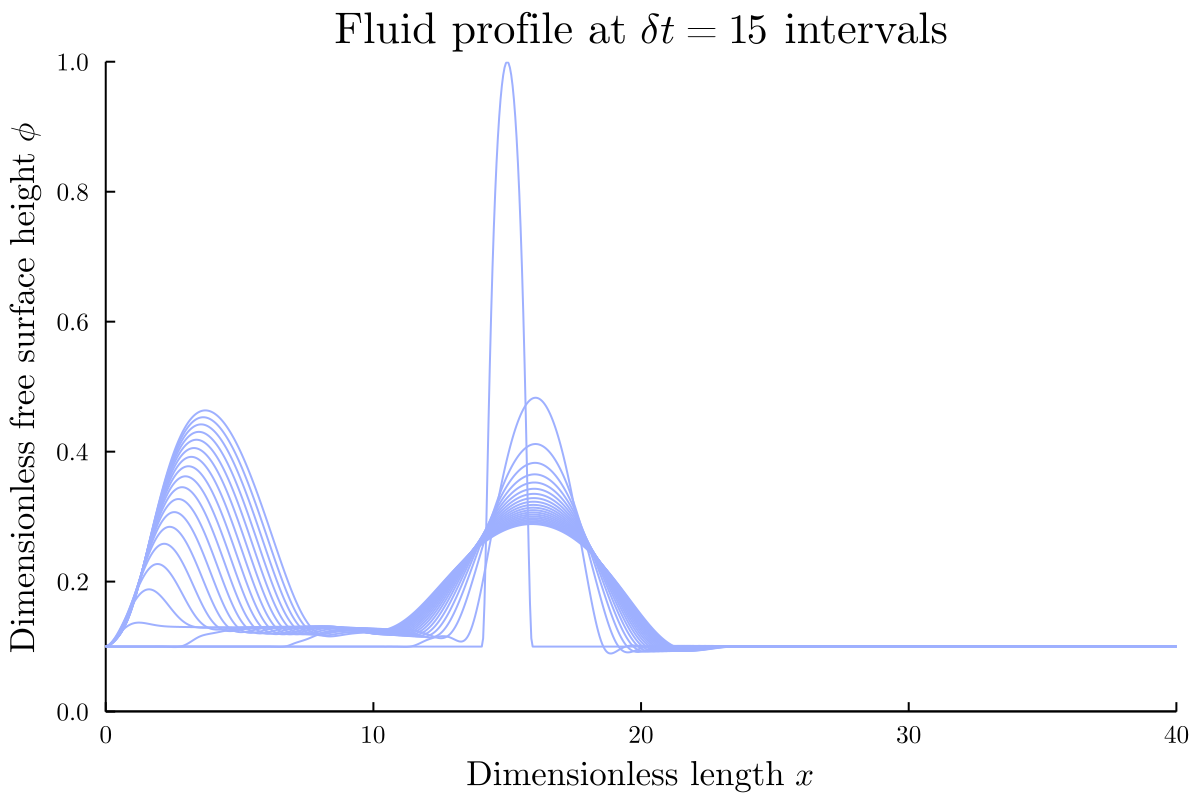

In [244]:
plt

┌ Info: Saved animation to 
│   fn = /var/folders/58/stll_lvs4sg8v_ry545yc1q80000gn/T/jl_3yTP3d.gif
└ @ Plots /Users/bsamineni/.julia/packages/Plots/cPJQu/src/animation.jl:114


Plots.AnimatedGif("/var/folders/58/stll_lvs4sg8v_ry545yc1q80000gn/T/jl_3yTP3d.gif")
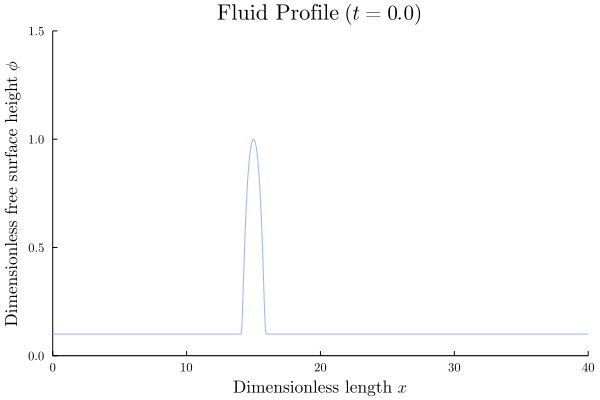

In [245]:
gif(anim, fps=30)

In [ ]:
using Dates

date = string(Dates.format(now(), "YYYYmmdd"))
time = string(Dates.format(now(), "HHMMSS"))
path = "../runs/$date/$time"

mkpath(path)

gif(anim, path * "/flow.gif", fps = 30)
savefig(plt, path * "/plt.png")
#fluid_data(sol, path)
save_params(path)